In [79]:
import numpy as np
import matplotlib.pyplot as plt
import time, copy, warnings

import torch
import torchvision

from torchvision import datasets, transforms

from sklearn import linear_model, svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from qiskit_algorithms.utils import algorithm_globals
np.random.seed(42)
algorithm_globals.random_seed = 12345

## Load the MNIST data

In [80]:
# Load MNIST dataset
def load_dataset(size,train=True):
    root = '~/Documents/image_datasets/MNIST'
    dataset = datasets.MNIST(root=root, train=train, download=True,
                             transform=transforms.Compose([
                                 transforms.Resize((size, size)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=(0.5,), std=(0.5,))
                             ]))
    return dataset


size = 16
trainset = load_dataset(train=True,size=size)
testset = load_dataset(train=False,size=size)



## Selecting data for specific digits

In [89]:
# Generate subset from dataset
def generate_subset(dataset, *classes):
    class_indices = torch.cat([torch.where(dataset.targets == c)[0] for c in classes])
    subset = torch.utils.data.Subset(dataset, class_indices)
    X = np.array([image.flatten().numpy() for image, _ in subset])
    y = np.array([label for _, label in subset])
    return X, y




# 
classes = [x for x in range(5)]
X_train, y_train = generate_subset(trainset, *classes)
X_test, y_test = generate_subset(testset, *classes)

# Randomly sample a subset of data (optional)
random_indices_test = np.random.choice(range(len(X_test)), 300, replace=False)
X_test, y_test = X_test[random_indices_test], y_test[random_indices_test]

random_indices_train = np.random.choice(range(len(X_train)), 3000, replace=False)
X_train, y_train = X_train[random_indices_train], y_train[random_indices_train]

In [90]:
import pandas as pd
print(len(classes))
print(pd.DataFrame(y_train).value_counts())

5
0
1    683
3    627
2    575
0    571
4    544
Name: count, dtype: int64


In [91]:
# size of the test and train set
print(f'Size of Training set is  {X_train.shape} \n and Testing set is {X_test.shape}')

Size of Training set is  (3000, 256) 
 and Testing set is (300, 256)


image_155 of size (16, 16) = (256,) :


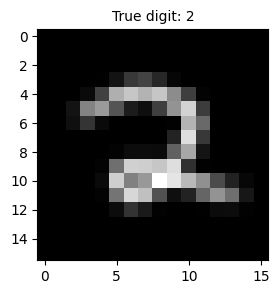

In [92]:

idx = np.random.randint(len(X_train[0]))
image, label = X_train[idx], y_train[idx]
print(f'image_{idx} of size {(size, size)} = {image.shape} :')

plt.figure(figsize=(3,3))
plt.imshow(image.reshape(size, size), cmap='gray')
plt.title(f'True digit: {label}', fontsize=10)
plt.show()

number of (features, qubits) = (256, 8)


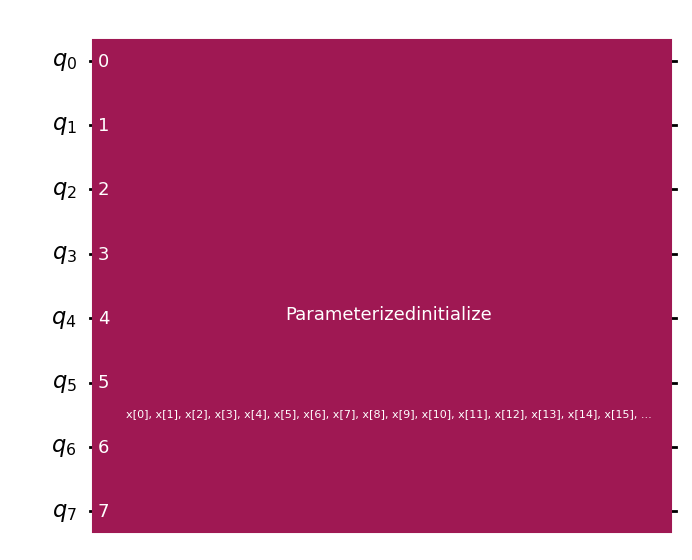

In [93]:
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.circuit.library import RawFeatureVector
import numpy as np

def create_feature_map(size, encoding):
    """
    Creates a feature map circuit based on the specified encoding type.

    Parameters:
        size (int): The size of the features.
        encoding (str): The encoding type. Choose from 'Pauli', 'Z', 'ZZ', or 'RawFeatureVector'.

    Returns:
        qiskit.QuantumCircuit: The feature map quantum circuit.
    """

    num_features = size ** 2
    num_qubits = num_features

    if encoding == 'Pauli':
        fm = PauliFeatureMap(feature_dimension=num_features, reps=1, paulis=['Z'])
    elif encoding == 'Z':
        fm = ZFeatureMap(feature_dimension=num_features, reps=1)
    elif encoding == 'ZZ':
        fm = ZZFeatureMap(feature_dimension=num_features, reps=2, entanglement="linear")
    elif encoding == 'RawFeatureVector':
        num_qubits = int(np.log2(num_features))
        fm = RawFeatureVector(feature_dimension=num_features)
    else:
        raise ValueError("Invalid encoding type. Choose from 'Pauli', 'Z', 'ZZ', or 'RawFeatureVector'.")

    print(f'number of (features, qubits) = {num_features, num_qubits}')

    return fm, num_qubits

# Example usage:
encoding = 'RawFeatureVector'
fm,num_qubits = create_feature_map(size, encoding)
fm.draw('mpl')


In [94]:
# parameters = pqc.parameters
# print(pqc)

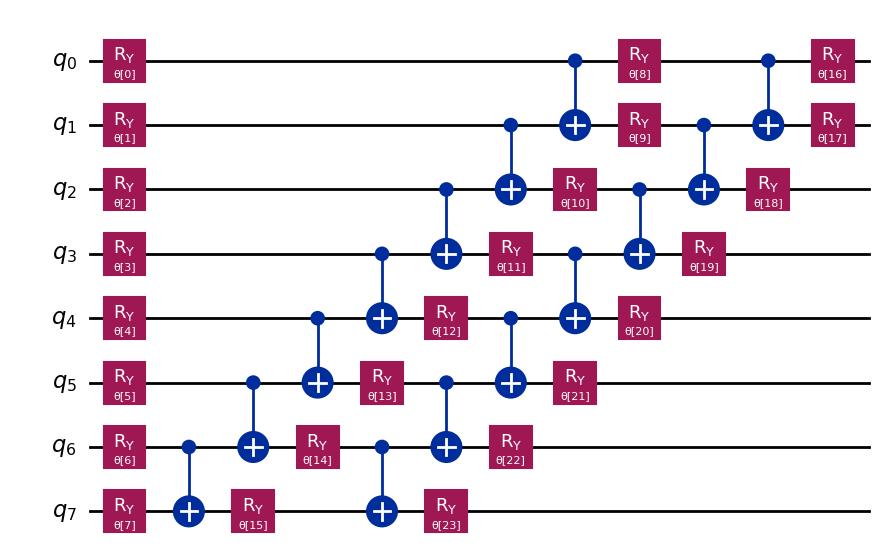

In [95]:
from qiskit.circuit.library import RealAmplitudes


pqc = RealAmplitudes(num_qubits=num_qubits, reps=2)
pqc.decompose().draw('mpl')

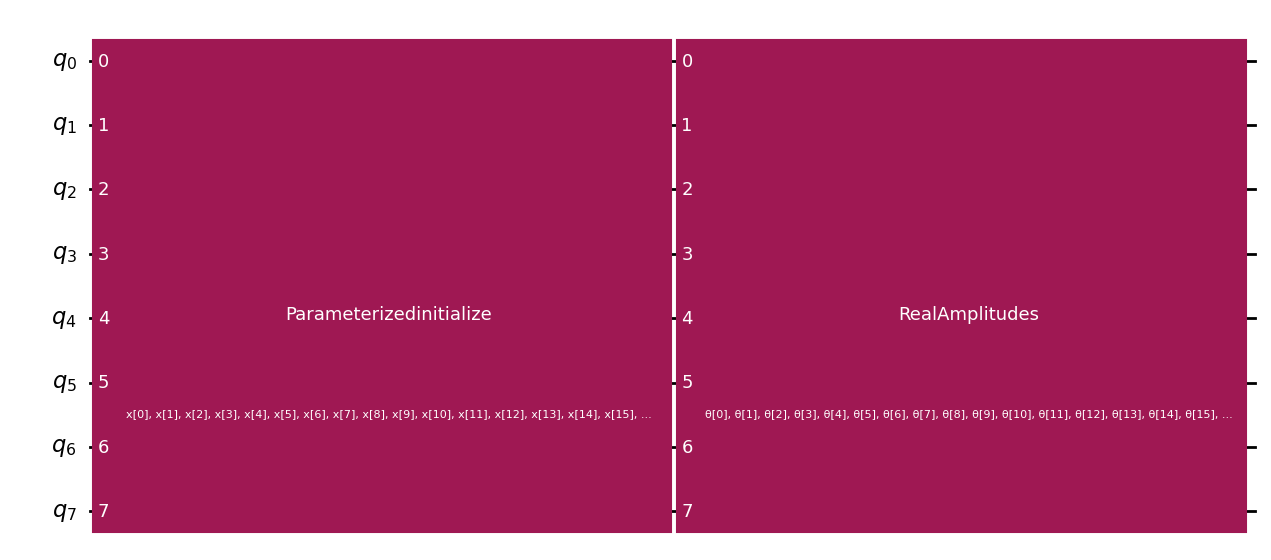

In [96]:
vqc_ckt = fm.compose(pqc)
# vqc_ckt=vqc_ckt.compose(fm)
vqc_ckt.draw('mpl')

## Custom PQCs

In [97]:
# from qiskit import QuantumCircuit
# from qiskit.circuit import ParameterVector

# def create_custom_circuit(num_qubits, num_repetitions):
#     # Define the parameter vector
#     params = ParameterVector('θ', length=num_qubits * 2 * num_repetitions)

#     # Create the quantum circuit
#     qc = QuantumCircuit(num_qubits)

#     for i in range(1,num_repetitions+1):
#         for qubit in range(num_qubits):
#             qc.ry(params[i*qubit], qubit)

#         for qubit in range(num_qubits - 2,-1,-1):
#             # print(qubit)
#             qc.cx(qubit, qubit + 1)

#     for qubit in range(num_qubits):
#         qc.ry(params[i*num_qubits + qubit], qubit)

#     return qc

# # Example usage:
# # num_qubits = 8


# pqc = create_custom_circuit(num_qubits=size, num_repetitions=2)
# print(pqc)


In [98]:
#cross entropy loss

In [99]:
from qiskit_algorithms.optimizers import COBYLA

# encoding = 'RawFeatureVector'
# fm, num_qubits = create_feature_map(size, encoding)

# Define ansatz
# pqc = RealAmplitudes(num_qubits=num_qubits, reps=3)

# Define optimizer
maxiterations = 100
optimizer = COBYLA(maxiter=maxiterations)

In [100]:
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC    



#------------------------------------------------------------------------------------------------

from IPython.display import clear_output
loss_func_vals = []
                                    
# a callback that can access the intermediate data during the optimization
def callback(weights, loss_func_val):
    clear_output(wait=True)
    loss_func_vals.append(loss_func_val)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.plot(range(len(loss_func_vals)), loss_func_vals)
    plt.show()


vqc = VQC(num_qubits=num_qubits, feature_map=fm, ansatz=pqc, loss='cross_entropy', optimizer=optimizer, callback=callback, sampler=None)

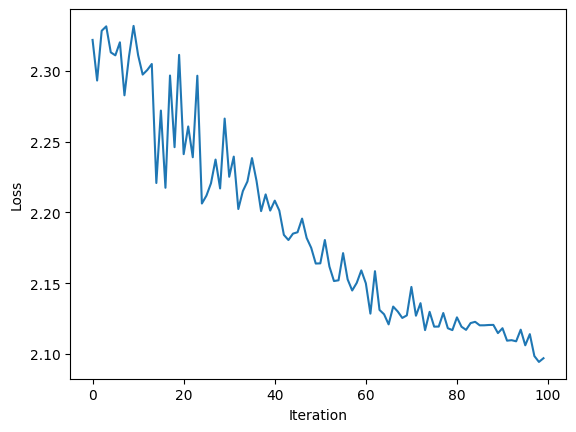

In [101]:

vqc.fit(X_train, y_train)

In [102]:
y_pred_test = vqc.predict(X_test)
y_pred_train = vqc.predict(X_train)
classification_test = classification_report(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)
classification_train = classification_report(y_train, y_pred_train)
cm_train = confusion_matrix(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_train = accuracy_score(y_train, y_pred_train)


In [103]:
print(f'Classification test: \n{classification_test}')
print(f'Confusion matrix test: \n{cm_test}')
print(f'Accuracy test: {accuracy_test}')
print(f'Classification train: \n{classification_train}')
print(f'Confusion matrix train: \n{cm_train}')
print(f'Accuracy train: {accuracy_train}')


Classification test: 
              precision    recall  f1-score   support

           0       0.49      0.73      0.59        63
           1       0.53      0.99      0.69        78
           2       0.67      0.36      0.47        61
           3       0.22      0.13      0.16        46
           4       1.00      0.02      0.04        52

    accuracy                           0.51       300
   macro avg       0.58      0.45      0.39       300
weighted avg       0.58      0.51      0.43       300

Confusion matrix test: 
[[46  0  3 14  0]
 [ 0 77  0  1  0]
 [ 7 27 22  5  0]
 [24  9  7  6  0]
 [16 33  1  1  1]]
Accuracy test: 0.5066666666666667
Classification train: 
              precision    recall  f1-score   support

           0       0.38      0.68      0.49       571
           1       0.50      0.99      0.66       683
           2       0.56      0.27      0.37       575
           3       0.28      0.14      0.19       627
           4       0.90      0.03      0.06   

In [104]:
# save results to file 
import time
#calculate time now
now = time.strftime("%c")

# file = open("results.txt", "a")
with open("results.txt", "a") as file:
    file.write(f'-----------Expirement conducted on-------- {now}\n')
    file.write(f'VQC with {encoding} encoding and {size}x{size} images\n')
    file.write(f'number of (train, test) examples = {len(X_train[0]), len(X_test[0])}\n')
    file.write(f'optimizer = {optimizer}\n')
    file.write(f'number of iterations = {maxiterations}\n')
    file.write(f'--------------Test results----------------\n')
    file.write(f'Classification test: \n{classification_test}\n')
    file.write(f'Confusion matrix test: \n{cm_test}\n')
    file.write(f'Accuracy test: {accuracy_test}\n')
    file.write(f'--------------Train results----------------\n')
    file.write(f'Classification train: \n{classification_train}\n')
    file.write(f'Confusion matrix train: \n{cm_train}\n')
    file.write(f'Accuracy train: {accuracy_train}\n')
file.close()


In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load the MNIST dataset
train_data = trainset# datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = testset#datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Filter the dataset to include only the desired classes (e.g., 0 and 1)
train_data.data = train_data.data[(train_data.targets == 0) | (train_data.targets == 1)]
train_data.targets = train_data.targets[(train_data.targets == 0) | (train_data.targets == 1)]
test_data.data = test_data.data[(test_data.targets == 0) | (test_data.targets == 1)]
test_data.targets = test_data.targets[(test_data.targets == 0) | (test_data.targets == 1)]

# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1} loss: {running_loss / len(train_loader)}')

# Evaluate the model on the test set
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test accuracy: {100 * correct / total}%')

ValueError: Expected input batch_size (4) to match target batch_size (64).